[toc]

# ML 学习笔记-7-XGBoost-3 Python 实战-1 BaseLearner的实现

说了这么多，还是来进行 XGBoost 实战吧。

## Base Learner 类

上一篇 Blog 中有提到，XGBoost 实际上定义了一个新类似于 CART 的 base learner。因此，我们第一件事就是实现这个 Base Learner


这个 Base Learner 的几个要素如下

1. 如何分裂结点：
    1. 损失函数是什么？
    根据 XGBoost 的原论文，根据下式来进行节点分裂。
        $$
        L_{s p l i t}= \frac{1}{2}\left[\frac{G_{L}^{2}}{H_{L}+\lambda}+\frac{G_{R}^{2}}{H_{R}+\lambda}-\frac{G_{I}^{2}}{H_{I}+\lambda}\right]-\gamma
        $$
    由于 $\gamma$ 是一个常数，因此可以省略。1 / 2 也是常数，省略它也不会影响最优分割点的选择。
    
    因此，可以定义某个节点上的损失为 
    $$
    loss = - \frac{G_I^2}{H_I + \lambda}
    $$
    2. 和 CART 树相同的二分递归分裂。实际上， XGBoost 的 base learner 的分裂算法有两种，一个是 exact greedy algorithm，这个就是 CART 中分裂节点的算法；另一种是 approximate greedy algorithm，这个实际上是 extract greedy algorithm 的一个分桶版本，之所以分桶是因为可以将一个桶中的样本当作一个整体去计算，因此会降低计算复杂度。这里，我们只实现比较简单的 exact greedy algorithm.
2. 对于任意一个节点 I 的输出由下式给出：
$$
w = -\frac{G_I}{H_I+\lambda}
$$

## 损失函数类

和 GBDT 一样，XGBoost 可以自定义损失函数，并且需要使用损失函数的一阶、二阶信息，因此先定义好一个可以计算一阶、二阶信息的损失函数

我们定义一个损失函数的类，然后继承这个类

In [1]:
import numpy as np
from matplotlib import pyplot as plt
class Loss:
    def predict(self, y, yhat):
        pass

    def gradient(self, y, yhat):
        pass

    def hessian(self, y, yhat):
        pass

    def __call__(self, y, yhat):
        return self.predict(y, yhat)

In [2]:
class MSE(Loss):
    def predict(self, y, yhat):
        return 0.5 * np.mean((y - yhat) ** 2)

    def gradient(self, y, yhat):
        return (yhat - y) / y.shape[0]

    def hessian(self, y, yhat):
        return np.ones_like(y) / y.shape[0]

## 结点类

In [3]:
class TreeNode:
    def __init__(self, split_feat_idx =None,  split_feat_val=None, left=None, right=None, depth=None, output=None):
        self.split_feat_idx = split_feat_idx
        self.split_feat_val = split_feat_val
        self.output = output
        self.depth = depth
        self.left = left
        self.right = right
        
    # 定义一个 __str__ 便于 print
    def __str__(self):
        return f"""{{
            depth: {self.depth} output: {self.output} split_feat_idx: {self.split_feat_idx} split_feat_val: {self.split_feat_val}
            left: {self.left}
            right: {self.right}}}"""

In [4]:

class XGBoostBaseLearner:
    def __init__(self, lambda_=0, gamma=0, max_depth=10, min_err_decrease=1e-5, min_samples_split=2):
        self.loss = MSE()
        self.lambda_ = lambda_
        self.gamma = gamma
        self.tree = None
        self.max_depth = max_depth
        self.min_err_decrease = min_err_decrease
        self.min_samples_split = min_samples_split
        self.cached_data = None
        self.depth = 0 # 回归树的深度

    def split(self, data, split_feat_idx, split_sample_idx):
        split_idx = list(data['features'][split_feat_idx]).index(split_sample_idx)

        left_data, right_data = {'features': {}}, {'features': {}}

        left_data['sample_idx'] = data['features'][split_feat_idx][:split_idx+1]
        right_data['sample_idx'] = data['features'][split_feat_idx][split_idx+1:]

        left_data['n_samples'] = left_data['sample_idx'].shape[0]
        right_data['n_samples'] = right_data['sample_idx'].shape[0]

        left_data['n_features'] = right_data['n_features'] = data['n_features']

        for feat_idx in data['features']:
            mask = np.isin(data['features'][feat_idx], left_data['sample_idx'])
            left_data['features'][feat_idx] = data['features'][feat_idx][mask]
            right_data['features'][feat_idx] = data['features'][feat_idx][~mask]

        return left_data, right_data

    def choose_best_split_feature(self, data):
        sample_indices  = data['sample_idx']
        n_samples, n_features = data['n_samples'], data['n_features']
        best_err_decrease = -float("inf")
        best_split_feat_idx = None
        best_split_sample_idx= None

        G_I = np.sum(self.cached_data['gradient'][sample_indices])
        H_I = np.sum(self.cached_data['hessian'][sample_indices])
        loss_before_split =  - G_I**2 / (H_I + self.lambda_)

        for feat_idx in range(n_features):
            G_L, G_R = 0, G_I
            H_L, H_R = 0, H_I
            for sample_j in data['features'][feat_idx][:-1]:
                G_L += self.cached_data['gradient'][sample_j]
                G_R -= self.cached_data['gradient'][sample_j]

                H_L +=  self.cached_data['hessian'][sample_j]
                H_R -=  self.cached_data['hessian'][sample_j]
                loss_L =  - G_L ** 2 / (H_L + self.lambda_)
                loss_R =   - G_R ** 2 / (H_R + self.lambda_)
                err_decrease = loss_before_split - (loss_L + loss_R) + 2 * self.gamma
                if err_decrease > best_err_decrease:
                    best_err_decrease = err_decrease
                    best_split_feat_idx = feat_idx
                    best_split_sample_idx = sample_j

        return best_split_feat_idx, best_split_sample_idx, best_err_decrease

    def create_tree(self, data, depth=1):
        root = TreeNode(depth=depth)
        # 节点对应的样本数过少或者树的深度过深
        if data['n_samples'] < self.min_samples_split or depth > self.max_depth:
            root.output = self.compute_output(data)
            self.depth = max(self.depth, depth)
            return root

        split_feat_idx, split_sample_idx, best_err_decrease = self.choose_best_split_feature(data)
        # 节点的 loss 减少过小
        if best_err_decrease < self.min_err_decrease:
            root.output = self.compute_output(data)
            self.depth = max(self.depth, depth)
            return root

        root.split_feat_idx = split_feat_idx
        root.split_feat_val = self.cached_data['X'][split_sample_idx, split_feat_idx]

        left_data, right_data =  self.split(data, split_feat_idx, split_sample_idx)
        root.left = self.create_tree(left_data, depth=depth + 1)
        root.right = self.create_tree(right_data, depth=depth + 1)
        return root

    def compute_output(self, data):
        sample_idx = data['sample_idx']
        return - np.sum(self.cached_data['gradient'][sample_idx]) / (np.sum(self.cached_data['hessian'][sample_idx]) + self.lambda_)

    def preprocess(self, X, y, yhat):
        """
        对建立 cache_data
        :param X:
        :return:
        """
        if yhat is None:
            yhat = np.zeros_like(y)
            
        self.cached_data= { 
            'X': X,
            'y': y,
            'yhat': yhat,
            'gradient': self.loss.gradient(y, yhat),
            'hessian': self.loss.hessian(y, yhat)
        }

        n_samples, n_features = X.shape
    
        # 用一个 dict 来表示 data
        # 这个 data 只保存样本的索引，而不保存值
        data = dict()
        # 这里使用 np.argsort 只排序 index，不排序原来的数据
        data['features'] = {feat_idx: np.argsort(self.cached_data['X'][:, feat_idx]) for feat_idx in range(n_features)}
        data['n_samples'], data['n_features'] = n_samples, n_features
        data['sample_idx'] = np.arange(n_samples)
        return data

    def fit(self, X, y, yhat=None):
        data = self.preprocess(X, y, yhat)
        self.tree = self.create_tree(data, depth=1)

    def _predict(self, node, x):
        """
        对一个样本进行预测
        """
        if not node.left and not node.right:
            return node.output
        if x[node.split_feat_idx] <= node.split_feat_val:
            return self._predict(node.left, x)
        else:
            return self._predict(node.right, x)


    def predict(self, X):
        yhat = np.array([self._predict(self.tree, x) for x in X])
        return yhat


## 测试

mse: 0.0023532641487166335


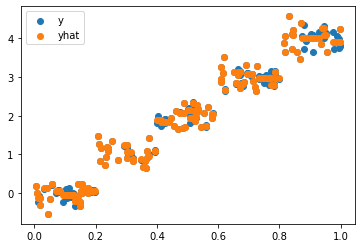

In [5]:
with open("ex0.txt") as f:
    data = np.array([list(map(float, line.strip().split())) for line in f])
    X = data[:, 0][:, np.newaxis]
    y = data[:, 1]

bst = XGBoostBaseLearner(max_depth=10)
bst.fit(X, y)

yhat = bst.predict(X)
print(f"mse: {MSE()(y, yhat)}")
plt.scatter(X, y, label='y')
plt.scatter(X, yhat, label='yhat')
plt.legend()
plt.show()